In [6]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import cv2
cap1 = cv2.VideoCapture(0)
cap2 = cv2.VideoCapture(1)
cv2.namedWindow('Webcam 1')
cv2.namedWindow('Webcam 2')
    
while True:
    ret1, frame1 = cap1.read()
    ret2, frame2 = cap2.read()
    cv2.imshow('Webcam 1', frame1)
    cv2.imshow('Webcam 2', frame2)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcams and destroy all windows
cap1.release()
cap2.release()
cv2.destroyAllWindows()

In [1]:
import numpy as np
import cv2
import random
import pygame
import pickle

def init_cameras(id1=0, id2=1):
    '''Инициализация и возврат 2х камер'''
    cap1 = cv2.VideoCapture(id1)
    cap2 = cv2.VideoCapture(id2)
    cv2.namedWindow('Webcam 1')
    cv2.namedWindow('Webcam 2')
    return cap1, cap2
    
def get_frame():
    '''Функция захвата фреймов с 2х камер, предполагает, что устройства уже открыты глобально'''
    ret1, frame1 = cap1.read()
    ret2, frame2 = cap2.read()
    cv2.imshow('Webcam 1', frame1)
    cv2.imshow('Webcam 2', frame2)
    return (frame1, frame2)

def setup_pygame(width, heigth):
    '''Инииализация и возврат экрана'''
    pygame.init()
    screen = pygame.display.set_mode((0, 0), pygame.FULLSCREEN)
    screen.fill((255, 255, 255))  # white
    return screen

def create_points(n_points, window_width, window_heigth):
    '''Функция создания точек по периметру экрана, между которыми будет бегать курсор 
    в количестве n_points на каждой из сторон экрана, порядок точек образует как бы 2 змейки'''
    points = [] 
    x1 = np.linspace(0, window_width, n_points, dtype = 'int') #как линейное пространство от 0 до 
    y1 = np.array([0, window_heigth]*(n_points//2)) #максимальной ширины в количестве n_points
    x2 = np.array([0, window_width]*(n_points//2))
    y2 = np.linspace(window_heigth, 0, n_points, dtype = 'int')
    points = list(zip(np.append(x1,x2), np.append(y1,y2)))

    return points

def move_to_points(screen, list_of_points, n, speed = 9999, capture = True):
    '''Функция генерации данных, принимает на вход pygame.screen, список крайних точек между которыми
    она добавит промежуточные точки в количестве n, speed - скорость перехода между точками, флаг 
    capture указывает на то нужно ли сохранять захваты с камер. Функция предполагает что если capture = True
    то глобально уже существуют два устройства opencv: cap1 и cap2, которые через фунцию get_frame вернут
    2 изображения, которые будут сохранены как соответствующие записи в результирующем списке. Таким же
    образом будут сохранены координаты курсора. '''    
    data = [] # Результат работы функции накапливается здесь
    clock = pygame.time.Clock() #Часы для задания скорости
    for ((sx, sy),(ex,ey)) in zip(list_of_points[:-1], #Берем координаты текущей и 
                                  list_of_points[1:]): #следующей точки
        for x, y in zip(np.linspace(sx, ex, n, dtype='int'), #Бежим по промежуточным координатам
                        np.linspace(sy, ey, n, dtype='int')):#
            
            for event in pygame.event.get(): #Для прерывания цикла кнопкой q
                if event.type == pygame.QUIT or (event.type == pygame.KEYDOWN and event.key == pygame.K_q):
                    pygame.quit()

            screen.fill((255, 255, 255)) #Заливаем экран       
            pygame.draw.circle(screen, (0, 0, 0), [x,y], 5)   #Рисуем курсор в виде черного кружка в текущих координатах        
            clock.tick(speed) #Скорость            
            pygame.display.update() #Обновляем экран          
    
            if capture: #Делаем захват с камер, если нужно
                frame1, frame2 = get_frame()
            else:
                frame1, frame2 = [],[]
            data.append({'x':x, 'y':y, 'camera1':frame1, 'camera2':frame2}) #Делаем текущую запись
    pygame.quit()  #Закрываем экран   
    return data

pygame 2.3.0 (SDL 2.24.2, Python 3.9.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [14]:
n_points = 8
WINDOW_WIDTH = 1920
WINDOW_HEIGTH = 1080

In [2]:
points = create_points(n_points, WINDOW_WIDTH, WINDOW_HEIGTH)
screen = setup_pygame(WINDOW_WIDTH,WINDOW_HEIGTH)

cap1, cap2 = init_cameras()
input()
data = move_to_points(screen, points, n=128, capture=True)

In [3]:
# with open('frames.pickle', 'wb') as handle:
#     pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
with open('frames.pickle', 'rb') as handle:
        data = pickle.load(handle)    

(1269, 680)


<Figure size 640x480 with 0 Axes>

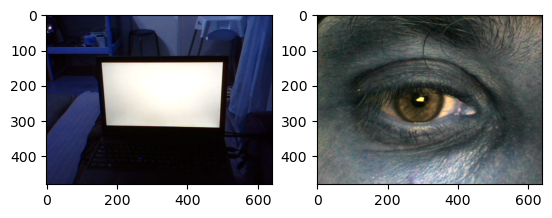

In [4]:
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import random
item = random.choice(data)
img1, img2, x, y = item['camera1'], item['camera2'], item['x'], item['y']

plt.figure()
f, axis = plt.subplots(1,2)
print((int(x),int(y)))
# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axis[0].imshow(img1)
axis[1].imshow(img2)


In [30]:
from torch.utils.data import Dataset, DataLoader
class EyeDataset(Dataset):
    def __init__(self, data, transform=None, target_transform=None):
        self.data = data
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        camera1 = self.data[idx]['camera1']
        camera2 = self.data[idx]['camera2']
        x = self.data[idx]['x']
        y = self.data[idx]['y']
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return camera1, camera2, x, y

def collate_batch(batch):
    camera1, camera2, x, y = [],[],[],[]
    for _data in batch:    
#         print(_data)
        camera1.append(_data[0]/256)
        camera2.append(_data[1]/256)
        x.append(_data[2]/WINDOW_WIDTH)
        y.append(_data[3]/WINDOW_HEIGTH)       
    camera1, camera2, x, y = np.array(camera1), np.array(camera2), np.array(x), np.array(y)
    return torch.FloatTensor(camera1), torch.FloatTensor(camera2), x, y
    
eyedataset = EyeDataset(data)
data_loader = DataLoader(eyedataset, batch_size=16, shuffle=True, collate_fn=collate_batch)

In [31]:
next(iter(data_loader))

(tensor([[[[0.0000, 0.0195, 0.1055],
           [0.0195, 0.0234, 0.0938],
           [0.0430, 0.0234, 0.0781],
           ...,
           [0.2461, 0.3008, 0.4727],
           [0.2461, 0.3008, 0.4727],
           [0.2461, 0.3008, 0.4727]],
 
          [[0.0039, 0.0234, 0.1133],
           [0.0234, 0.0273, 0.1016],
           [0.0430, 0.0234, 0.0859],
           ...,
           [0.2461, 0.3125, 0.5000],
           [0.2539, 0.3086, 0.5000],
           [0.2617, 0.3203, 0.5078]],
 
          [[0.0117, 0.0195, 0.1250],
           [0.0352, 0.0234, 0.1094],
           [0.0508, 0.0195, 0.0859],
           ...,
           [0.2461, 0.3203, 0.5078],
           [0.2461, 0.3203, 0.5078],
           [0.2500, 0.3242, 0.5156]],
 
          ...,
 
          [[0.1211, 0.1367, 0.2695],
           [0.1133, 0.1328, 0.2852],
           [0.1055, 0.1250, 0.2930],
           ...,
           [0.0430, 0.0195, 0.0781],
           [0.0469, 0.0156, 0.0820],
           [0.0469, 0.0156, 0.0820]],
 
          [[0.1250,

In [32]:
import torch
import torchvision.models as models
from torch import nn

vgg11_1 = models.vgg11(pretrained=True)
vgg11_2 = models.vgg11(pretrained=True)
precls_out = 8

C:\Users\Ilja\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Ilja\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
for i in [5,5]:
    del (vgg11_1.classifier[i])
    del (vgg11_2.classifier[i])

vgg11_1.classifier[3]= nn.Linear(4096, precls_out)
vgg11_2.classifier[3]= nn.Linear(4096, precls_out)

In [34]:
class EyeTracker(nn.Module):
    def __init__(self, precls_out):
        super(EyeTracker, self).__init__()
        self.vgg1 = vgg11_1
        self.vgg2 = vgg11_2
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(precls_out*2, precls_out)
        self.fc2 = nn.Linear(precls_out, 2)
        self.activ = nn.ReLU()

    def forward(self, image1, image2):
        out1 = self.vgg1(image1)
        out2 = self.vgg1(image2)
        out = torch.cat((out1, out2),dim=1)
        out = self.fc1(out)
        out = self.activ(out)
        out = self.fc2(out)       
        return out
    
eyeTracker = EyeTracker(8)



In [41]:
for batch in data_loader:
    image1, image2, x, y = batch
    image1 = image1.permute(0,3,2,1)
    image2 = image2.permute(0,3,2,1)
#     print(image1.shape)
    out = eyeTracker(image1, image2)
    break
# eyeTracker([data[10]['camera1']], [data[10]['camera2']])


In [42]:
out

tensor([[-0.3088,  0.2499],
        [-0.3651,  0.3212],
        [-0.3724,  0.3786],
        [-0.3651,  0.3446],
        [-0.3556,  0.3030],
        [-0.3715,  0.3206],
        [-0.3386,  0.3148],
        [-0.4003,  0.3670],
        [-0.3116,  0.2447],
        [-0.3632,  0.3205],
        [-0.3799,  0.3306],
        [-0.3739,  0.3312],
        [-0.4023,  0.4132],
        [-0.3320,  0.2713],
        [-0.3565,  0.2977],
        [-0.3090,  0.2395]], grad_fn=<AddmmBackward0>)